In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

/Users/pontusdejounge/miniforge3/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
df = pd.read_csv('incoming_packages.csv')

# Analysera datan

In [5]:
print(df)

           date  total_packages  cooled_packages  fire_packages   
0    2020-01-01            1745              370            488  \
1    2020-01-02            1847              308            402   
2    2020-01-03            1842              314            394   
3    2020-01-04             664              131            181   
4    2020-01-05             871              137            190   
..          ...             ...              ...            ...   
846  2022-04-26            2268              467            503   
847  2022-04-27            2466              432            641   
848  2022-04-28            2436              545            556   
849  2022-04-29            2302              368            547   
850  2022-04-30            1270              227            331   

     normal_packages  
0                887  
1               1137  
2               1134  
3                352  
4                544  
..               ...  
846             1298  
847        

In [6]:
print("Null värden")
print(df.isnull().sum())

Null värden
date               0
total_packages     0
cooled_packages    0
fire_packages      0
normal_packages    0
dtype: int64


# Finns det någon säsongsvariation? I så fall, vilka?

Ja, det finns en årlig säsongsvariation i datan. Specifikt finns det en nedåtgående trend runt juli varje år och en topp i november till december.

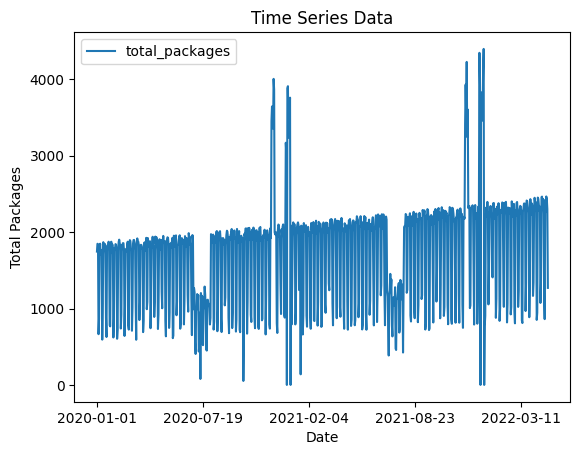

In [7]:
df.plot(x='date', y='total_packages')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Total Packages')
plt.show()

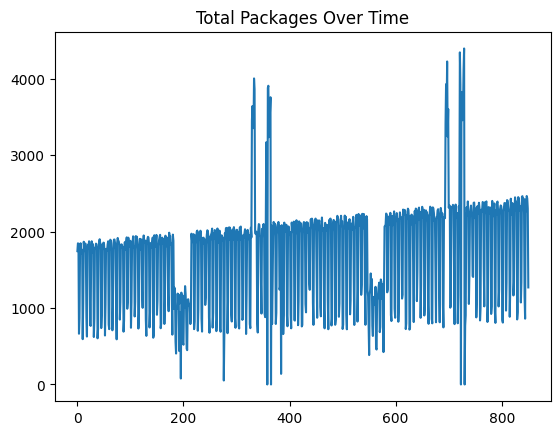

In [8]:
df['total_packages'].plot()
plt.title('Total Packages Over Time')
plt.show()

# Det finns spikar i november och december, vad kan det bero på?

Jul är en återkommande högtid med högre antal paket skickade än det normala som borde påverka antal paket skickade i november och december.

In [9]:
df['date'] = pd.to_datetime(df['date'])

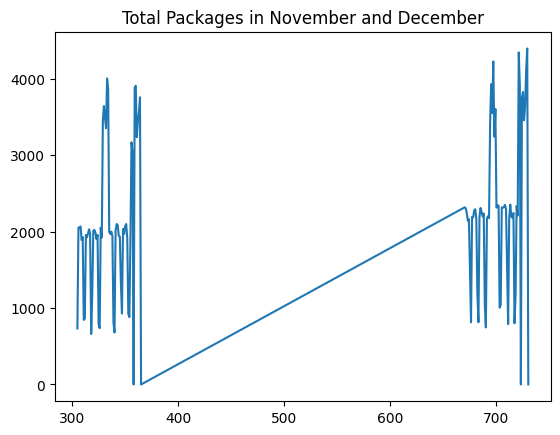

In [10]:
nov_dec = df[(df['date'].dt.month == 11) | (df['date'].dt.month == 12)]
nov_dec['total_packages'].plot()
plt.title('Total Packages in November and December')
plt.show()

# Finns det någon trend?

Runt juli 2020 verkar det finnas en övergripande nedåtgående trend som verkar återkomma, då det ser lika ut i juli 2021. Sedan är det en stark uppåtgående trend kring november december 2020 och 2021.

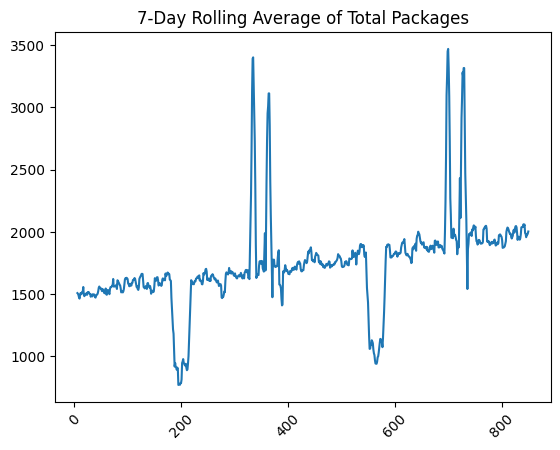

In [11]:
df['date'] = df['date'].dt.strftime('%Y-%m-%d')
rolling_mean = df['total_packages'].rolling(window=7).mean()
rolling_mean.plot()
plt.xticks(rotation=45)
plt.title('7-Day Rolling Average of Total Packages')
plt.show()


# Finns det några dagar med extrema värden?

Ja det finns dagar med extrema värden/högre än det normala, inför julen sent i november och julveckan i december.

In [12]:
from scipy.stats import zscore

df['z_score'] = zscore(df['total_packages'])
outliers = df[(df['z_score'] > 3) | (df['z_score'] < -3)]
print(outliers)

           date  total_packages  cooled_packages  fire_packages   
333  2020-11-29            4005              715            917  \
334  2020-11-30            3865              826           1044   
359  2020-12-25            3881              730           1088   
360  2020-12-26            3909              740            768   
695  2021-11-26            3930              728            851   
697  2021-11-28            4227              885           1179   
721  2021-12-22            4346             1027           1077   
722  2021-12-23            3924              970            983   
725  2021-12-26            3828              536            789   
728  2021-12-29            4122              893            920   
729  2021-12-30            4397              933           1246   

     normal_packages   z_score  
333             2373  3.323928  
334             1995  3.118534  
359             2063  3.142007  
360             2401  3.183086  
695             2351  3.213895

# Träna en facebook prophet modell

# Träna modellen på all data före 2022-04-01

In [13]:
df = df.rename(columns={'date': 'ds', 'total_packages': 'y'})
train_df = df[df['ds'] < '2022-04-01']

model = Prophet()
model.fit(train_df)

11:32:13 - cmdstanpy - INFO - Chain [1] start processing
11:32:13 - cmdstanpy - INFO - Chain [1] done processing


# Testa modellen på all data från 2022-04-01 och framåt

In [14]:
test_df = df[df['ds'] >= '2022-04-01']
future = model.make_future_dataframe(periods=len(test_df), freq='D')
future_forecast = model.predict(future)

# Hur har modellen prognostiserat träningsdatan

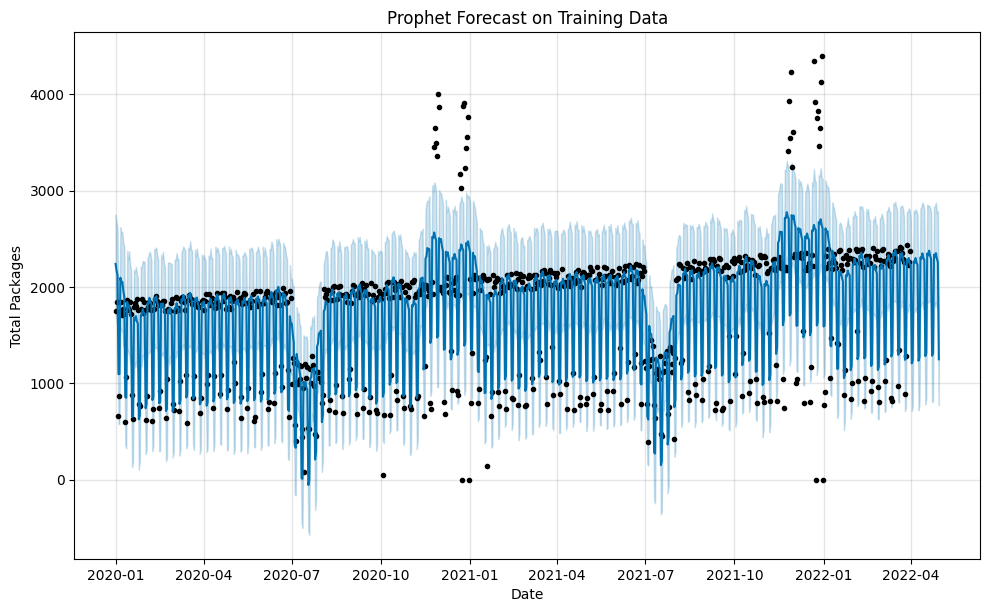

In [15]:
fig = model.plot(future_forecast, xlabel='Date', ylabel='Total Packages')
plt.title('Prophet Forecast on Training Data')
plt.show()

# Rita ut modellens komponenter (trend och säsongsvariation)

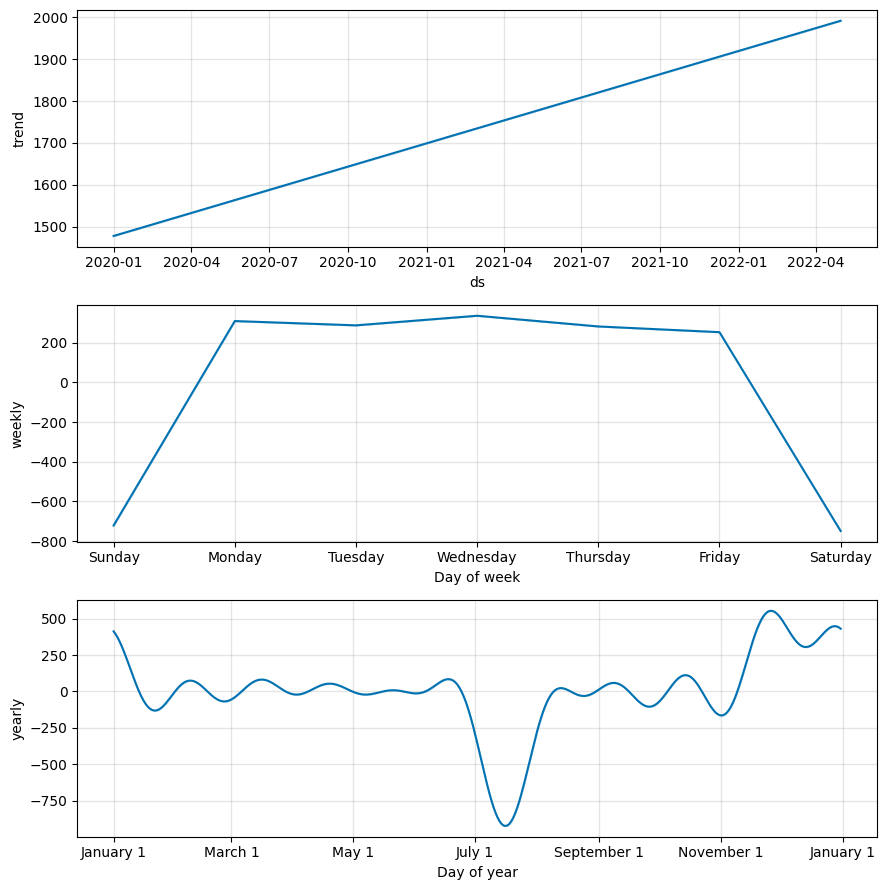

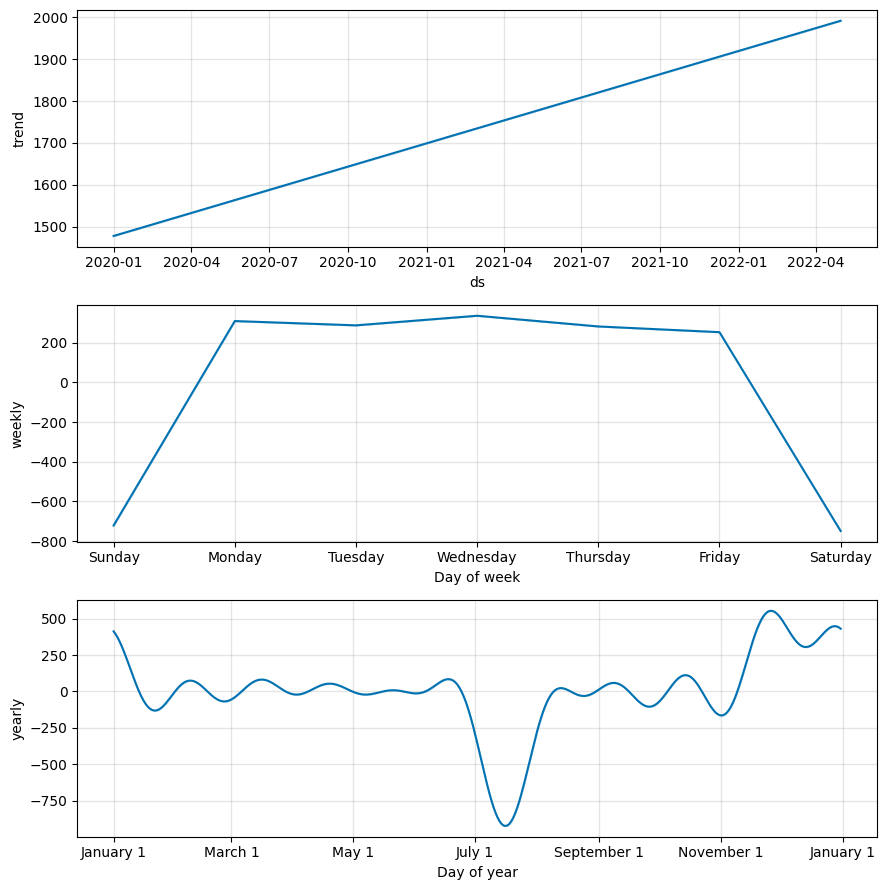

In [16]:
model.plot_components(future_forecast)

# Kör modellen mot testdatan och se om den presterar bättre än planeringen på 2000 paket om dagen

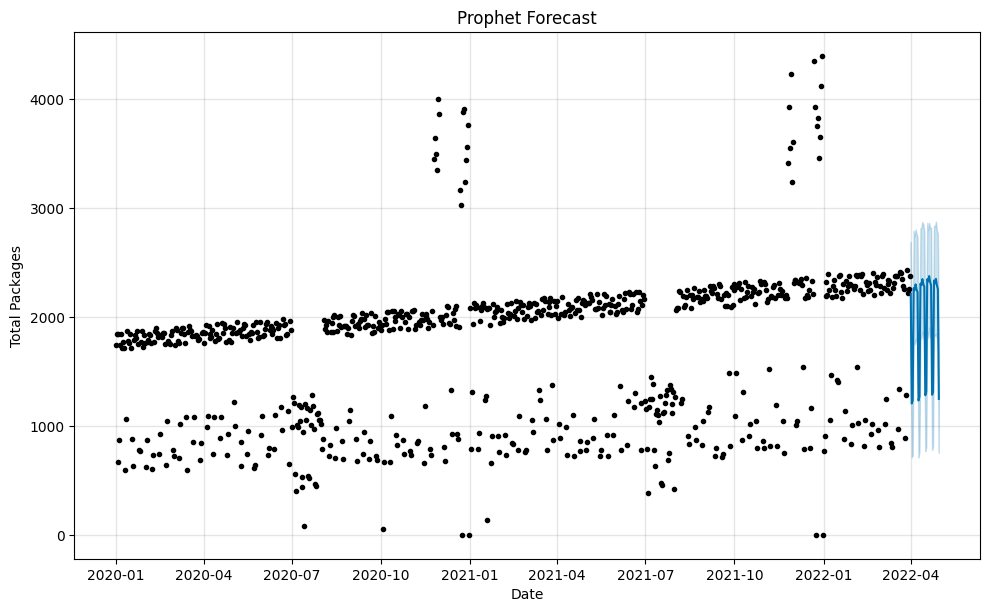

In [17]:
test_forecast = model.predict(test_df)
fig = model.plot(test_forecast, xlabel='Date', ylabel='Total Packages')
plt.title('Prophet Forecast')
plt.show()

# För att jämföra modellen med ursprungliga planeringen ska AME (absolute mean error) användas

In [18]:
from sklearn.metrics import mean_absolute_error

mae_forecast = mean_absolute_error(test_df['y'], test_forecast['yhat'])
plan = [2000] * len(test_df)
mae_plan = mean_absolute_error(test_df['y'], plan)
print("Forecast",mae_forecast)
print("Plan",mae_plan)
if mae_forecast < mae_plan:
    print("The model performs better than the plan of 2000 packages per day.")
else:
    print("The plan of 2000 packages per day performs better than the model.")

Forecast 117.51677761411868
Plan 524.9666666666667
The model performs better than the plan of 2000 packages per day.


# Gör en prognostisering för Juni 2022 och rita ut.

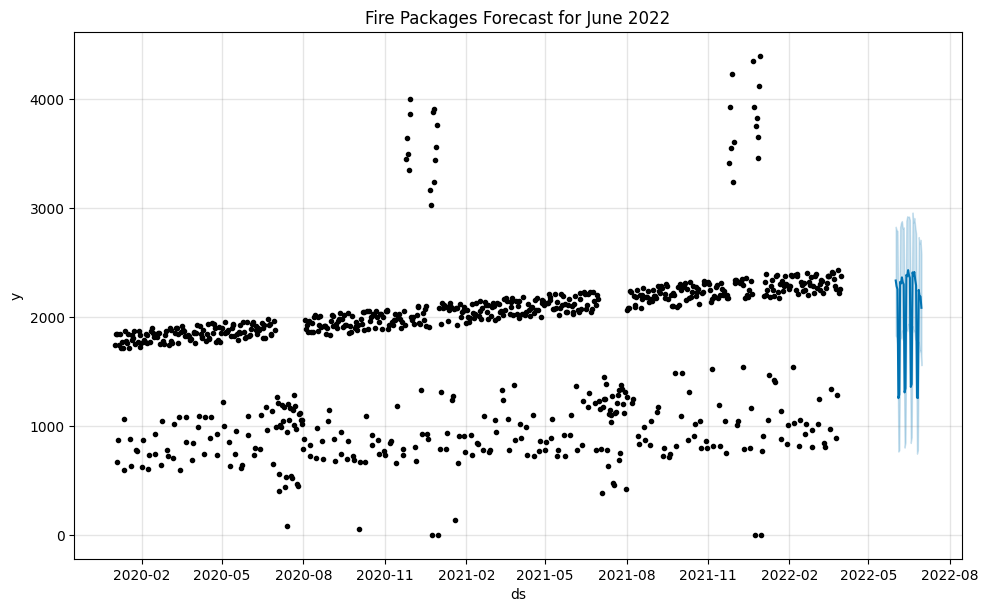

In [19]:
total_june = pd.DataFrame({'ds': pd.date_range(start='2022-06-01', end='2022-06-30', freq='D')})
forecast_june = model.predict(total_june)

fig = model.plot(forecast_june)
plt.title('Fire Packages Forecast for June 2022')
plt.show()

# VG

# Träna ytterligare tre facebook prophet modeller.
# Prognostiseringen för totala antalet paket ska användas som input för varje modell.

# ○ En för normala paket.

In [20]:
df_normal = pd.read_csv('incoming_packages.csv')
df_normal = df_normal.rename(columns= {'date': 'ds', 'normal_packages': 'y'})
df_normal['ds'] = pd.to_datetime(df_normal['ds'])
test_forecast['ds'] = pd.to_datetime(future_forecast['ds'])

df_normal = df_normal.merge(future_forecast[['ds', 'yhat']], on='ds', how='left')
df_normal = df_normal.rename(columns={'yhat': 'total_forecast'})

train_normal = df_normal[df_normal['ds'] < '2022-04-01']
test_normal = df_normal[df_normal['ds'] >= '2022-04-01']

model_normal = Prophet()
model_normal.add_regressor('total_forecast')
model_normal.fit(train_normal)
forecast_normal = model_normal.predict(test_normal)

11:32:14 - cmdstanpy - INFO - Chain [1] start processing
11:32:14 - cmdstanpy - INFO - Chain [1] done processing


# Räkna ut medelvärdet av fel för varje dag i testdatan

In [35]:
mae_forecast = mean_absolute_error(test_normal['y'], forecast_normal['yhat'])
print("Mean Absolute Error",mae_forecast)

Mean Absolute Error 114.3319006597557


# Rita ut modellens komponenter (trend och säsongsvariation)

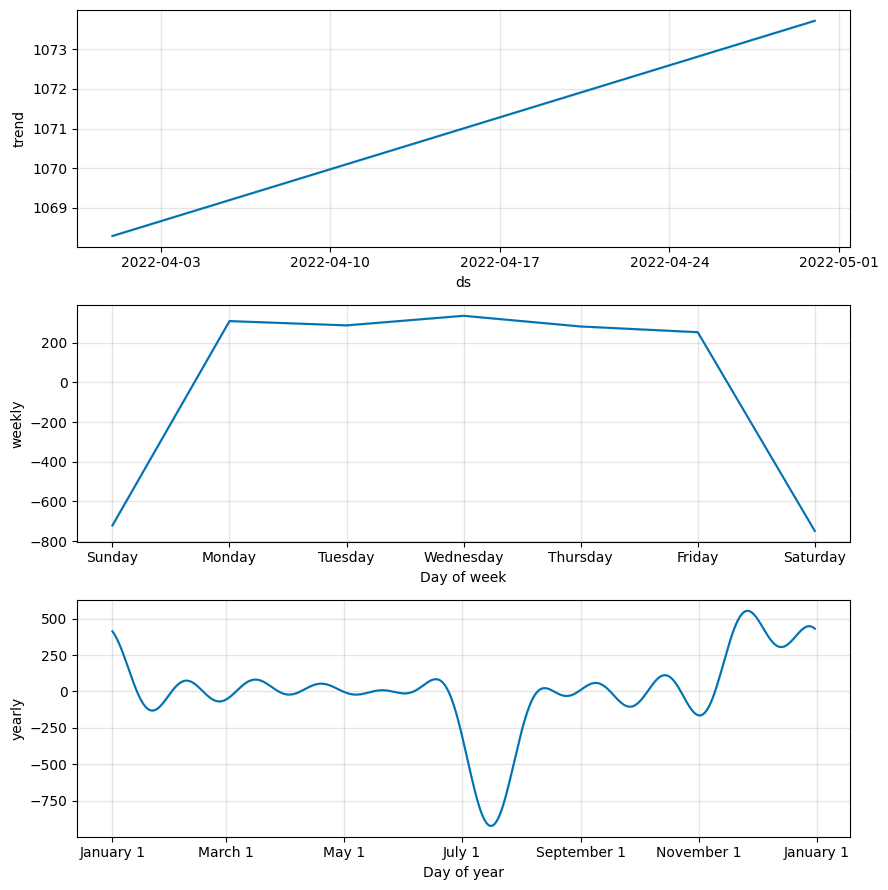

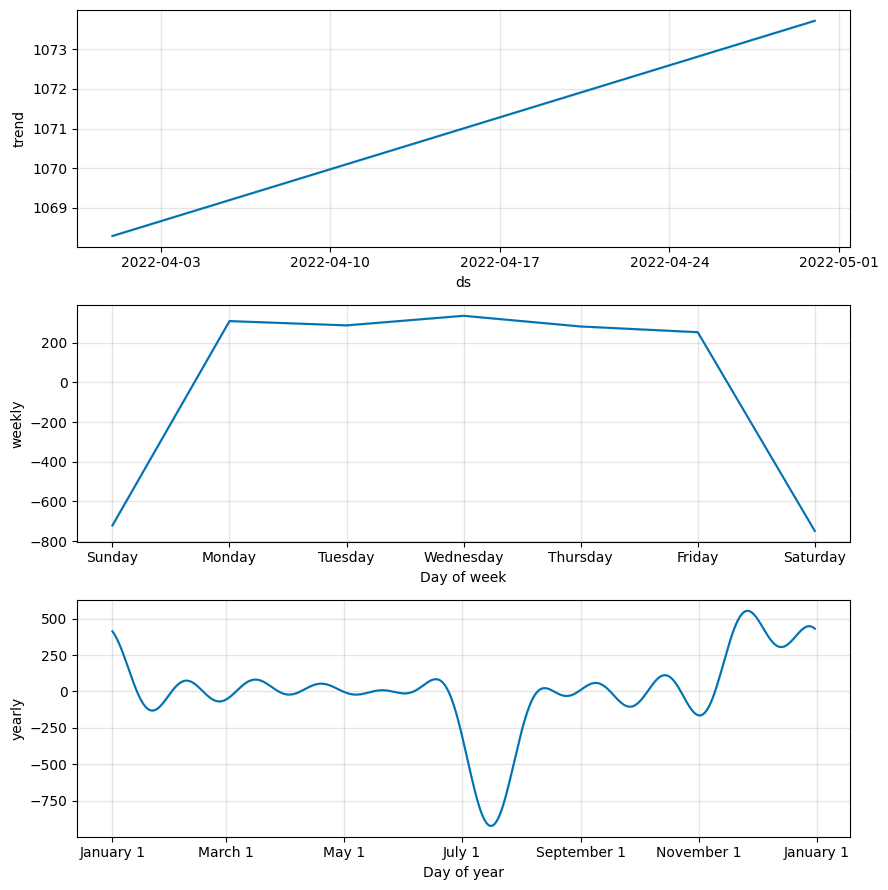

In [22]:
model.plot_components(forecast_normal)

# Gör en prognostisering för Juni 2022 och rita ut.

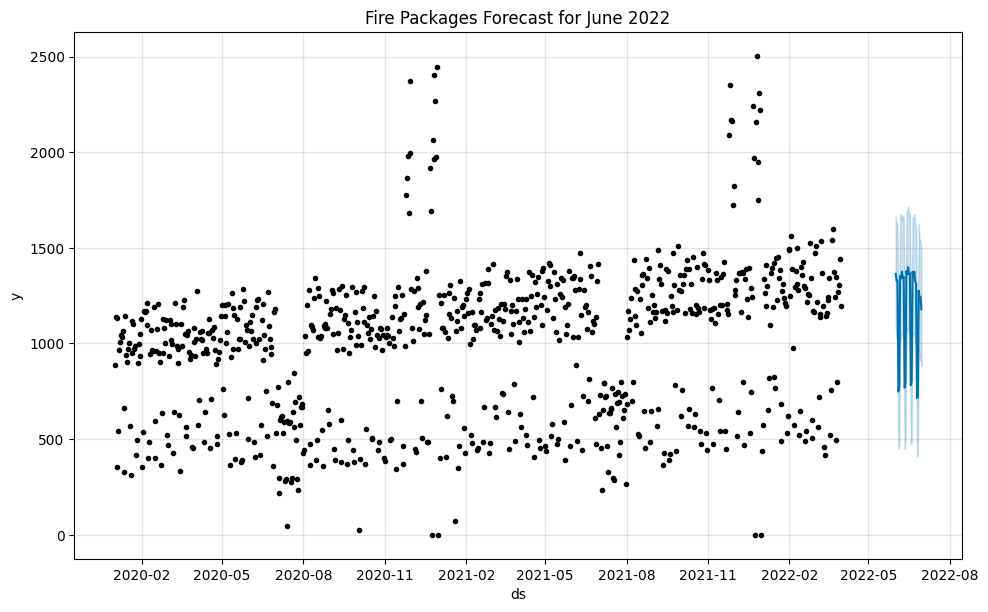

In [23]:
future_normal = pd.DataFrame({'ds': pd.date_range(start='2022-06-01', end='2022-06-30')})
future_normal = future_normal.merge(forecast_june[['ds', 'yhat']], on='ds', how='left')
future_normal = future_normal.rename(columns={'yhat': 'total_forecast'})

forecast_fire = model_normal.predict(future_normal)
fig = model_normal.plot(forecast_fire)
plt.title('Fire Packages Forecast for June 2022')
plt.show()

# ○ En för kylda paket.

In [24]:
df_chilled = pd.read_csv('incoming_packages.csv')
df_chilled = df_chilled.rename(columns= {'date': 'ds', 'cooled_packages': 'y'})
df_chilled['ds'] = pd.to_datetime(df_chilled['ds'])
test_forecast['ds'] = pd.to_datetime(future_forecast['ds'])

df_chilled = df_chilled.merge(future_forecast[['ds', 'yhat']], on='ds', how='left')
df_chilled = df_chilled.rename(columns={'yhat': 'total_forecast'})

train_chilled = df_chilled[df_chilled['ds'] < '2022-04-01']
test_chilled = df_chilled[df_normal['ds'] >= '2022-04-01']

model_chilled = Prophet()
model_chilled.add_regressor('total_forecast')
model_chilled.fit(train_chilled)
forecast_chilled = model_normal.predict(test_chilled)

11:32:15 - cmdstanpy - INFO - Chain [1] start processing
11:32:15 - cmdstanpy - INFO - Chain [1] done processing


# Räkna ut medelvärdet av fel för varje dag i testdatan

In [34]:
mae_forecast = mean_absolute_error(test_chilled['y'], forecast_chilled['yhat'])
print("Mean Absolute Error",mae_forecast)

Mean Absolute Error 137.97839131081383


# Rita ut modellens komponenter (trend och säsongsvariation)

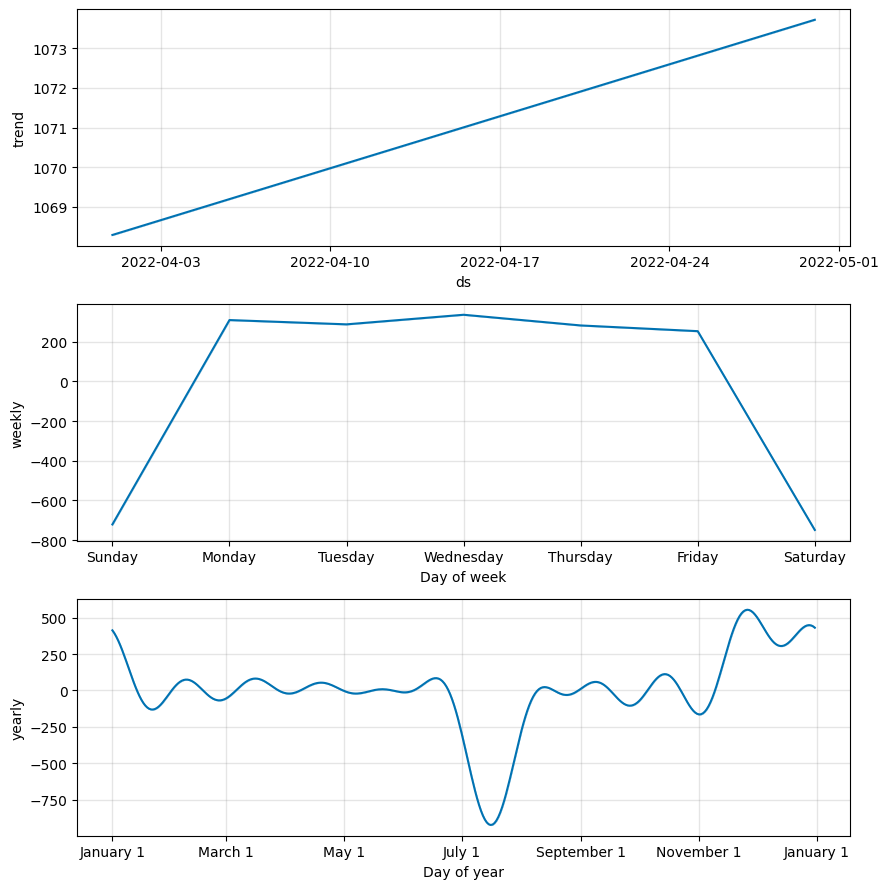

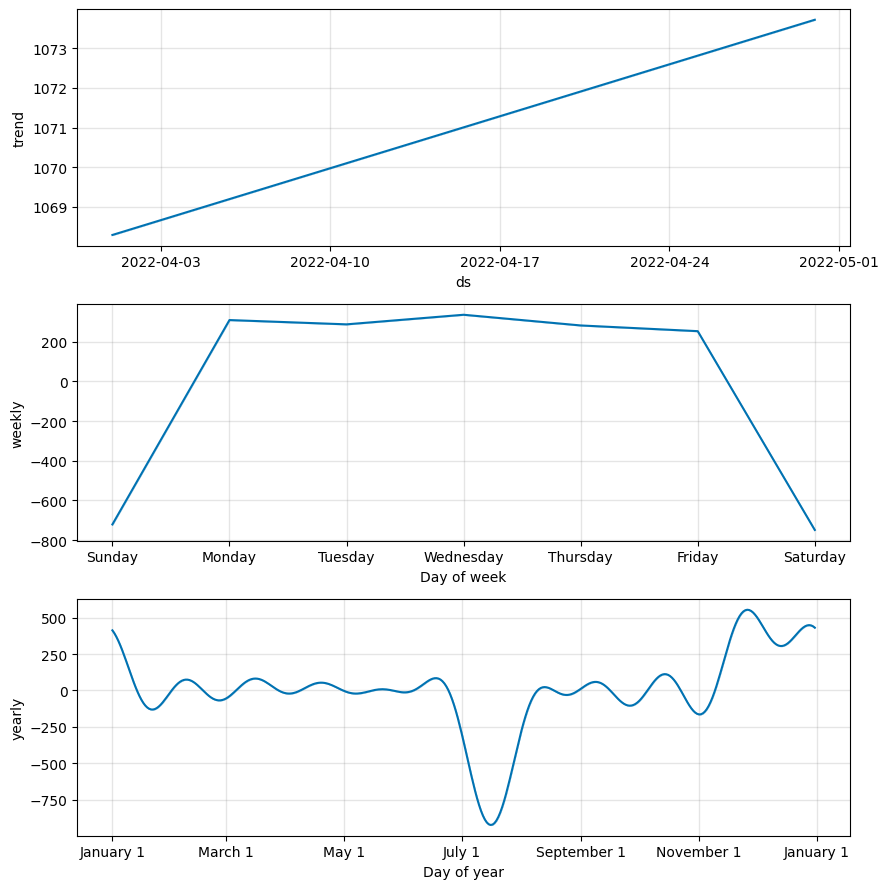

In [26]:
model.plot_components(forecast_chilled)

# Gör en prognostisering för Juni 2022 och rita ut.

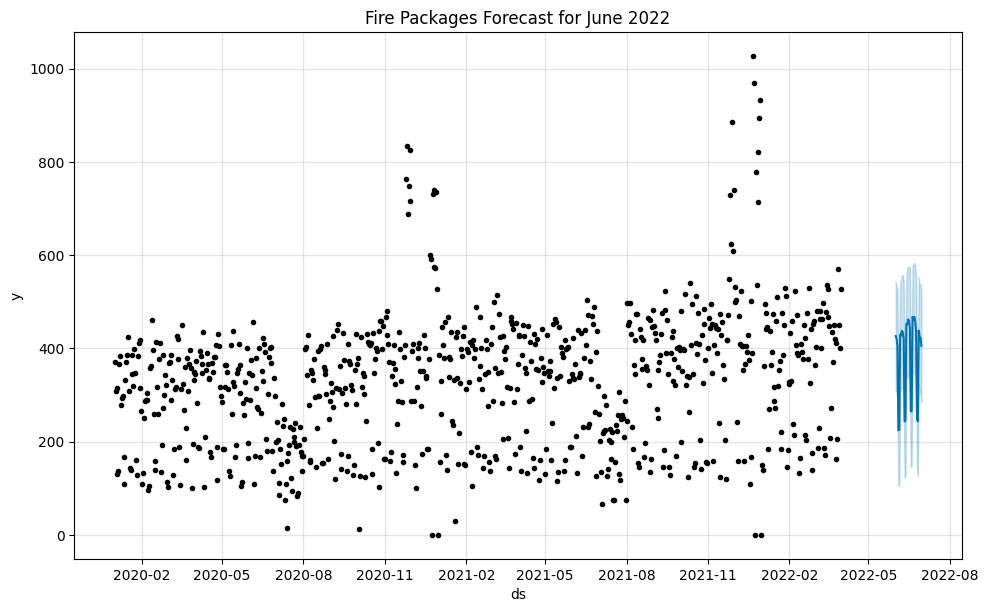

In [27]:
future_chilled = pd.DataFrame({'ds': pd.date_range(start='2022-06-01', end='2022-06-30')})
future_chilled = future_chilled.merge(forecast_june[['ds', 'yhat']], on='ds', how='left')
future_chilled = future_chilled.rename(columns={'yhat': 'total_forecast'})

forecast_chilled = model_chilled.predict(future_chilled)
fig = model_chilled.plot(forecast_chilled)
plt.title('Fire Packages Forecast for June 2022')
plt.show()

# ○ En för brandfarliga paket.

In [28]:
df_fire = pd.read_csv('incoming_packages.csv')
df_fire = df_fire.rename(columns= {'date': 'ds', 'fire_packages': 'y'})
df_fire['ds'] = pd.to_datetime(df_fire['ds'])
test_forecast['ds'] = pd.to_datetime(future_forecast['ds'])

df_fire = df_fire.merge(future_forecast[['ds', 'yhat']], on='ds', how='left')
df_fire = df_fire.rename(columns={'yhat': 'total_forecast'})

train_fire = df_fire[df_fire['ds'] < '2022-04-01']
test_fire = df_fire[df_fire['ds'] >= '2022-04-01']

print(df_fire.columns)

model_fire = Prophet()
model_fire.add_regressor('total_forecast')
model_fire.fit(train_fire)
forecast_fire = model_fire.predict(test_fire)

11:32:16 - cmdstanpy - INFO - Chain [1] start processing
11:32:16 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'total_packages', 'cooled_packages', 'y', 'normal_packages',
       'total_forecast'],
      dtype='object')


# Räkna ut medelvärdet av fel för varje dag i testdatan

In [33]:
mae_forecast = mean_absolute_error(test_fire['y'], forecast_fire['yhat'])
print("Mean Absolute Error",mae_forecast)

Mean Absolute Error 155.81085644353956


# Rita ut modellens komponenter (trend och säsongsvariation)

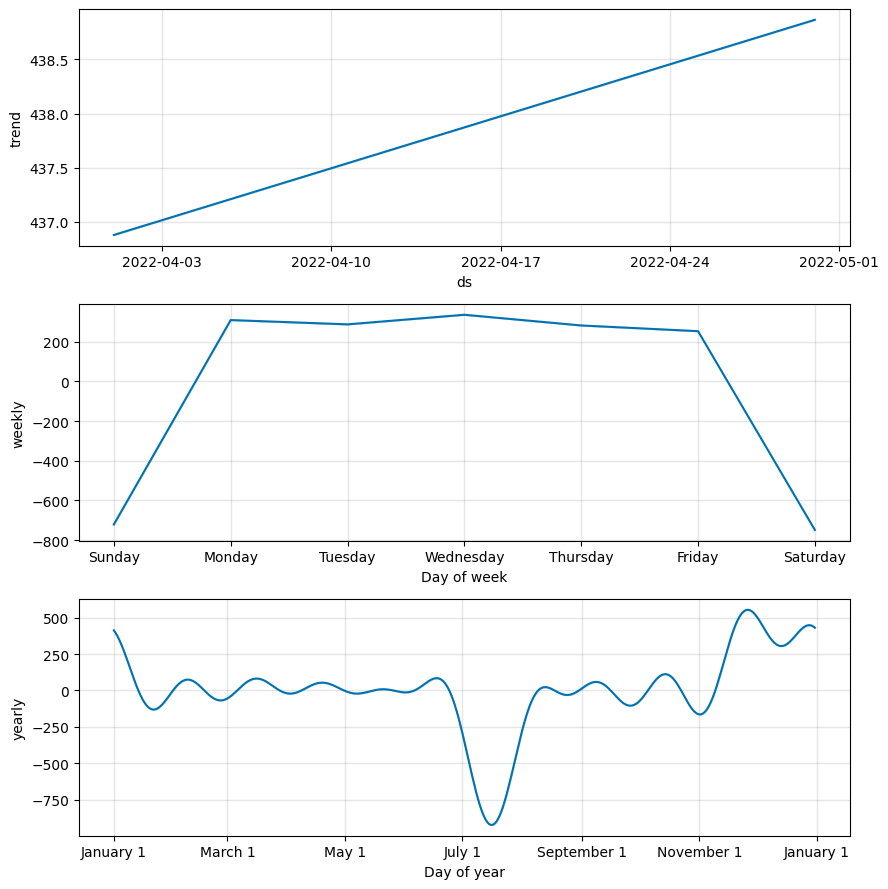

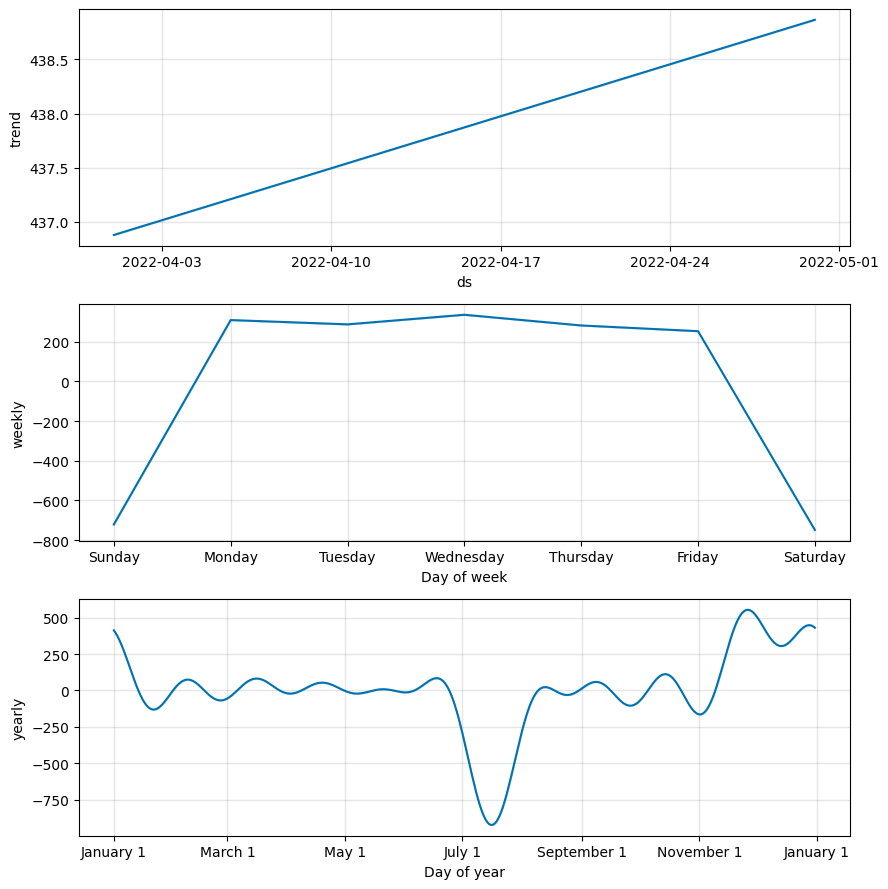

In [30]:
model.plot_components(forecast_fire)

# Gör en prognostisering för Juni 2022 och rita ut.

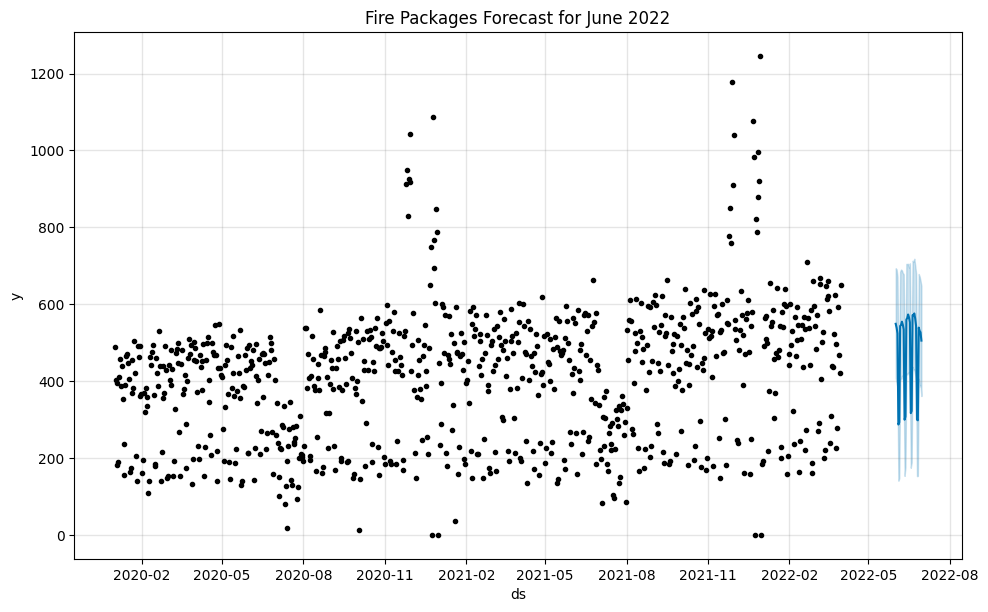

In [31]:
future_fire = pd.DataFrame({'ds': pd.date_range(start='2022-06-01', end='2022-06-30')})
future_fire = future_fire.merge(forecast_june[['ds', 'yhat']], on='ds', how='left')
future_fire = future_fire.rename(columns={'yhat': 'total_forecast'})

forecast_fire = model_fire.predict(future_fire)
fig = model_fire.plot(forecast_fire)
plt.title('Fire Packages Forecast for June 2022')
plt.show()